# Logistic Regression

In [27]:
import pandas as pd
import numpy as np

Import the already splitted datasets.

In [28]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
train_labels = np.ravel(train_labels)

test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

## Preprocessing Pipeline

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 


In [30]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

In [31]:
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

Given that this model supports both categorical and numerical features, in the various attempts to find the best model, combinations of both were tried out. This is why the pipeline also supports categorical features.

In [32]:
cat_features = [col for col in ['is_tarmac', 'length_cat', 'climb_cat'] if col not in columns_to_drop]
# Define the preprocessing for numeric and categorical features
numeric_features = [col for col in train_data.columns if col not in cat_features]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', 'passthrough', cat_features)
    ]
)

## Logistic Regression Model

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

We perform a randomized search to find the best hyperparameters for the model. In addition, we also perform some trials using under and over sampling to see if the model improves.

In [34]:
log_classifier = LogisticRegression(max_iter=2000, class_weight={0:1, 1:10}, random_state=42)

#pipeline
pipe = imbpipeline(steps=[('preprocessor', preprocessor),
                            ('sampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
                       ('classifier', log_classifier)])

parameters = {
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
    'classifier__penalty': ['l1', 'l2', None],
    'classifier__tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__class_weight': ['balanced', None]
}


scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': get_scorer("precision"),
    'sensitivity': get_scorer("recall"),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

In [35]:
# Perform randomized search cross-validation
random_search = RandomizedSearchCV(pipe, 
                                   param_distributions=parameters, 
                                   scoring=scoring,
                                   cv=5, # already stratified
                                   verbose=1, 
                                   n_jobs=-1, 
                                   refit='f1',
                                   n_iter=50)
random_search.fit(train_data, train_labels)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_p

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['climb_total',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'cyclist_experience',
                                                                                'avg_relative_position',
                                                                                'position_entropy',
                                                                                'top_20_entropy']),
                                                                              ('cat',
                                                                               'passthrough',
                                                                               [])])),
                                             ('sampler',
                                              RandomUnderSampler(random_state=42,
                                                                 sampling_strategy=0.5)),
                                             ('...
                            'f1': make_scorer(f1_score, response_method='predict', average=binary),
                            'precision': make_scorer(precision_score, response_method='predict', average=binary),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(recall_score, response_method='predict', average=binary),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

## Model Assessment

### Validation scores

In [36]:
# extract the results of the randomized search and best model idx
cv_results =random_search.cv_results_
best_model = random_search.best_estimator_
best_index = random_search.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.4547, Std: 0.0378
Specificity - Mean: 0.8487, Std: 0.0248
Accuracy - Mean: 0.7964, Std: 0.0184
Precision - Mean: 0.3175, Std: 0.0234
Roc_auc - Mean: 0.7456, Std: 0.0142
F1 - Mean: 0.3727, Std: 0.0199


### Test scores

Accuracy: 0.768
Recall: 0.456
Precision: 0.305
Sensitivity: 0.456
Specificity: 0.821
F1 Score: 0.365
ROC AUC Score: 0.639


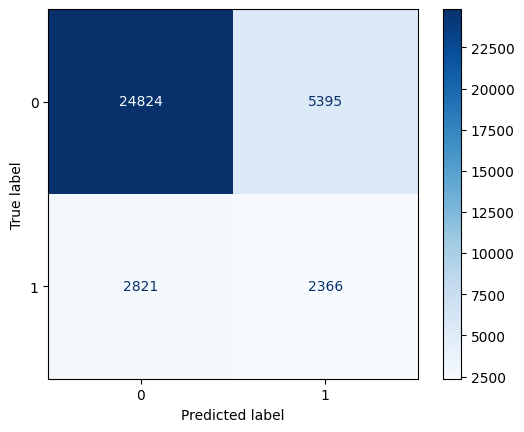

In [37]:
# Predict on the test data
test_predictions = random_search.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [38]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.82      0.86     30219
           1       0.30      0.46      0.37      5187

    accuracy                           0.77     35406
   macro avg       0.60      0.64      0.61     35406
weighted avg       0.81      0.77      0.79     35406



## Model Save

In [39]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)
# Save the best model
joblib.dump(best_model, 'best_models/nb.pkl')

['best_models/nb.pkl']

## Results
We tried several combinations of features and hyperparameters, but the models doesn't seem to improve much, probably due to the nature of the data. We extensively tried to improve the model using under and over sampling, but the results were not satisfactory. Anyway the best model is the one using under sampling with the undersampling technique from SciKit learn library and sampling strategy of 0.5.

NORMAL
Validation results of the best model:
Sensitivity - Mean: 0.6914, Std: 0.0279
Specificity - Mean: 0.6799, Std: 0.0431
Accuracy - Mean: 0.6814, Std: 0.0346
Precision - Mean: 0.2506, Std: 0.0195
Roc_auc - Mean: 0.7456, Std: 0.0138
F1 - Mean: 0.3670, Std: 0.0194

SMOTE
Validation results of the best model:
Sensitivity - Mean: 0.6925, Std: 0.0293
Specificity - Mean: 0.6784, Std: 0.0454
Accuracy - Mean: 0.6803, Std: 0.0363
Precision - Mean: 0.2502, Std: 0.0201
Roc_auc - Mean: 0.7456, Std: 0.0137
F1 - Mean: 0.3667, Std: 0.0198

UNDER
Validation results of the best model:
Sensitivity - Mean: 0.4547, Std: 0.0378
Specificity - Mean: 0.8487, Std: 0.0248
Accuracy - Mean: 0.7964, Std: 0.0184
Precision - Mean: 0.3175, Std: 0.0234
Roc_auc - Mean: 0.7456, Std: 0.0142
F1 - Mean: 0.3727, Std: 0.0199

